## PSD for E2, trying to generate a PSD plot (framework for future plots).

In [73]:
#Purisa Jasmine Simmons
#July 2018

#Overview: PSD for E2, trying to generate a PSD plot (framework for future plots).
#Based on Method V of this paper: https://journals.ametsoc.org/doi/pdf/10.1175/2010JTECHO724.1

#First, parse the data from the .CSV file.
#This data comes from a controlled experiment (CE2), so we are assuming that 
#all of the vertical accelerations are contained in IMUA2.

%matplotlib inline

import numpy as np
import peakutils
import statsmodels.api as sm
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d
from scipy import signal
import matplotlib.pyplot as plt

from plotly import tools
import plotly.offline
import plotly.graph_objs as go

import math
import re

#Reading data from filename_r
filename_r = "Motion_CE2_14827.CSV"
read_file = open(filename_r, "r")

#Initialize lists
t1 = 0 
t2 = 0
time_o_list = []  #list of time offsets; t_out = current_time - prev_time 
time_e_list = []
imu1_list = []
imu2_list = []   #list of estimated accelerations
imu3_list = []

time_e_list1 = []
time_e_list2 = []
time_e_list3 = []
acc_list = []
acc_list1 = []   #seperate out each sub-experiment
acc_list2 = []
acc_list3 = []

disp_list = []     #list of calculated vertical displacements
disp_t_list = []   #list of time_elapsed for each vertical displacement

with open(filename_r, 'r') as f: 
    for line in f:
        #print line     #helps with debugging
        str_array = line.split(',')  #separates each line into an array on commas

        #-------Calculating Time Offset--------#
        if str_array[1] == "Time":
            t1 = 0
            t2 = 0
            time_o_list.append(0)  #initialize time_list with 0
            time_e_list.append(0)
            
        else:
            t2 = str_array[1]    #Using "Time" Column instead of "UTC" column
        
        
        if (t2 != 0 and t1 != 0 and str_array[2] != "N/A"):
            t_out = float(t2) - float(t1) #measured in secs
            t_out = (t_out*(10**-3))

            last_ti = len(time_o_list) - 1 #index of last time_offset
            last_te = time_e_list[last_ti] #last time_elapsed
            time_e_list.append(last_te + t_out)  #last time_elapsed + time_offset
            time_o_list.append(t_out)
      
            #print(("Time offset is: %f") % (t_out))
        
        if (str_array[2] != "N/A" and str_array[3] != "N/A" and \
            str_array[4] != "N/A" and str_array[2] != "IMU A1"):


            #Scale raw to get correct units in m/s^2
            g_const = 512            #g is the constant for gravity: 500 (measured in g?)
            gravity = -9.80665

            ax = float(str_array[2])  #x-axis (horizontal direction 1)
            ay = float(str_array[3])  #y-axis, affected by gravity (vertical)
            az = float(str_array[4])  #z-axis (horizontal direction 2)

            #print(("ax: %f") % ax) 
            #print(("ay: %f") % ay)
            #print(("az: %f") % az)
        
            imu1_list.append(ax)
            imu2_list.append(ay)
            imu3_list.append(az)
        
            acc = float(float(float(ay/g_const)*gravity)-gravity)
            acc_list.append(acc)
        
            #print('Vertical acceleration is: %f' % ay)


        #Reset t1 and t2 after t_out is calculated
        t1 = t2
        t2 = 0
 

## PSD Step 1: Seperate each of the subexperiments into its own acc lists

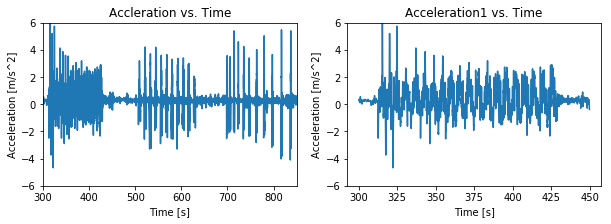

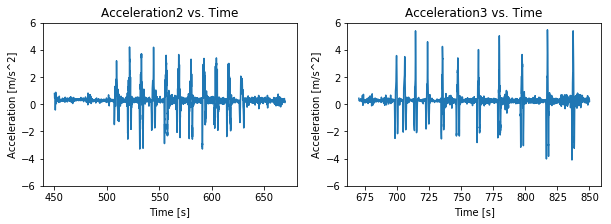

In [74]:
#Seperate each of the subexperiments into its own acc lists.
#i.e. subexperiment1 corresponds to acc1, (subexperiment2 => acc2), etc.
i = 0

while (i < (len(acc_list) - 1)):
    if (time_e_list[i] > 300 and time_e_list[i] <= 450):
        acc_list1.append(acc_list[i])
        time_e_list1.append(time_e_list[i])
    if (time_e_list[i] > 450 and time_e_list[i] <= 670):
        acc_list2.append(acc_list[i])
        time_e_list2.append(time_e_list[i])
    if (time_e_list[i] > 670 and time_e_list[i] <= 850):
        acc_list3.append(acc_list[i])
        time_e_list3.append(time_e_list[i])
    i = i + 1
    
#Plot the subexperiments to verify correctness:
time_array = np.array(time_e_list)
acc_array = np.array(acc_list)   #acc_list gets vertical acceleration from y-axis imu2
  
time_array1 = np.array(time_e_list1)
acc_array1 = np.array(acc_list1)
time_array2 = np.array(time_e_list2)
acc_array2 = np.array(acc_list2)
time_array3 = np.array(time_e_list3)
acc_array3 = np.array(acc_list3)
  
    
##Plotting:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array, acc_array)
ax1.set_title("Accleration vs. Time")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_xlim([300,850])
ax1.set_ylim([-6,6])

ax2.plot(time_array1, acc_array1)
ax2.set_title("Acceleration1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Acceleration [m/s^2]")
ax2.set_ylim([-6,6])

ax3.plot(time_array2, acc_array2)
ax3.set_title("Acceleration2 vs. Time")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("Acceleration [m/s^2]")
ax3.set_ylim([-6,6])

ax4.plot(time_array3, acc_array3)
ax4.set_title("Acceleration3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel("Acceleration [m/s^2]")
ax4.set_ylim([-6,6])

plt.show()
    

## PSD Step 2: Detrend the data 

In [75]:
##PSD Step 2: Detrend the data 
dacc_array1 = signal.detrend(acc_array1)
dacc_array2 = signal.detrend(acc_array2)
dacc_array3 = signal.detrend(acc_array3)

##Remove outliers--points greater than 3x the standard deviation
std1 = np.std(dacc_array1)*3
std2 = np.std(dacc_array2)*3
std3 = np.std(dacc_array3)*3

#Returns a new array that is the same as the array passed in, with its outliers removed.
def removed_outliers(a_array, time_array, std):
    i = 0
    count = 0
    ret_accs = []
    ret_times = []
    while i < (len(a_array)):
        if abs(a_array[i]) < std:
            ret_accs.append(a_array[i])
            ret_times.append(time_array[i])
        else:
            count = count + 1  #could help with debugging to know how many outliers removed
        i = i + 1  
    return count, ret_accs, ret_times;
        
count1, ro_array1, ro_time1 = removed_outliers(dacc_array1, time_array1, std1)
count2, ro_array2, ro_time2 = removed_outliers(dacc_array2, time_array2, std2)
count3, ro_array3, ro_time3 = removed_outliers(dacc_array3, time_array3, std3)

#print(len(dacc_array1))
#print(count1)
#print(len(ro_array1))

##Set up data interpolation (using Cubic Splines) for use in next step
cs1 = CubicSpline(ro_time1, ro_array1)
cs2 = CubicSpline(ro_time2, ro_array2)
cs3 = CubicSpline(ro_time3, ro_array3)


##interpld returns a function that relates y=ro_array (without outliers) to x=time:
#cs1 = interp1d(ro_time1, ro_array1)
#cs2 = interp1d(ro_time2, ro_array2)
#cs3 = interp1d(ro_time3, ro_array3)

#Now, use this interpolation to put points back into the original graph:
def add_interpolated_pts(a_array, time_array, std, cs):
    i = 0
    ret_acc = []
    while i < (len(a_array)):
        if abs(a_array[i]) > std:
            ret_acc.append(cs(time_array[i]))
        else:
            ret_acc.append(a_array[i])
        i = i + 1  
    return ret_acc;


#These are the new arrays with the interpolated points (which we will
#feed into a Kalman filter later).
interp_array1 = add_interpolated_pts(dacc_array1, time_array1, std1, cs1)
interp_array2 = add_interpolated_pts(dacc_array2, time_array2, std2, cs2)
interp_array3 = add_interpolated_pts(dacc_array3, time_array3, std3, cs3)

#print(len(interp_array1))
#print(len(dacc_array1))

##To verify that the two arrays are different(i.e. pts were actually interpolated):
j = 0
count = 0
while (j < (len(interp_array1) - 1)):
    if interp_array1[j] != dacc_array1[j]:
        count = count + 1
    j = j + 1
        
#print(count)
    

## Plot all of the data, to see visually:

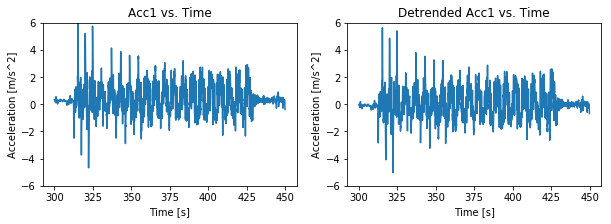

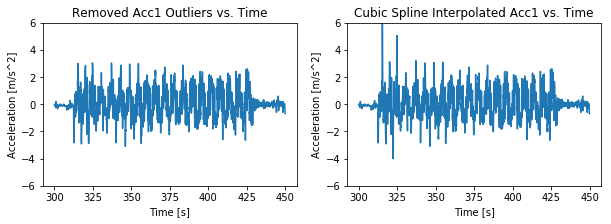

In [76]:
##Plotting the results for the 1st sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

ax1.plot(time_array1, acc_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])

ax2.plot(time_array1, dacc_array1)
ax2.set_title("Detrended Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

ax3.plot(ro_time1, ro_array1)
ax3.set_title('Removed Acc1 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])

ax4.plot(time_array1, interp_array1)
ax4.set_title("Cubic Spline Interpolated Acc1 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()

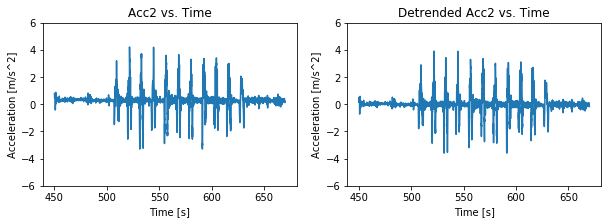

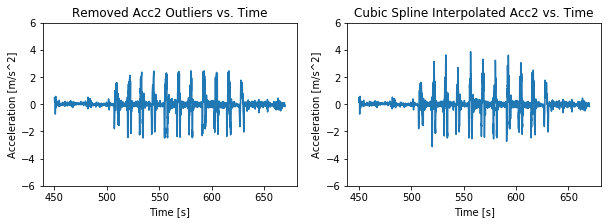

In [77]:
##Plotting the results for the 2nd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array2, acc_array2)
ax1.set_title('Acc2 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array2, dacc_array2)
ax2.set_title("Detrended Acc2 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time2, ro_array2)
ax3.set_title('Removed Acc2 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array2, interp_array2)
ax4.set_title("Cubic Spline Interpolated Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()




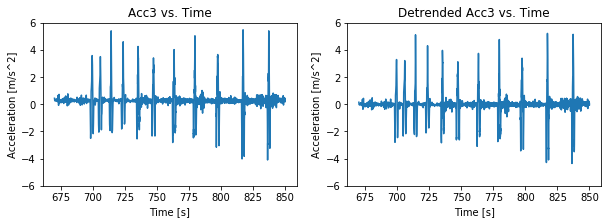

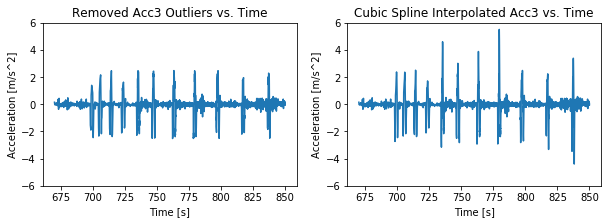

In [78]:
##Plotting the results for the 3rd sub-experiment:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)


##Subplots for acc2
ax1.plot(time_array3, acc_array3)
ax1.set_title('Acc3 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax1.set_ylim([-6,6])
ax2.plot(time_array3, dacc_array3)
ax2.set_title("Detrended Acc3 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')
ax2.set_ylim([-6,6])

##Subplots for acc3
ax3.plot(ro_time3, ro_array3)
ax3.set_title('Removed Acc3 Outliers vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax3.set_ylim([-6,6])
ax4.plot(time_array3, interp_array3)
ax4.set_title("Cubic Spline Interpolated Acc3 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')
ax4.set_ylim([-6,6])

plt.show()



Here, I'm implementing a lowess filter instead of a Kalman 
 filter right now because it seems simpler to implement.




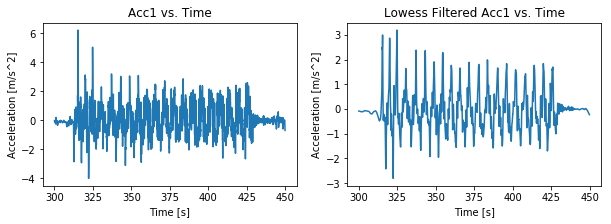

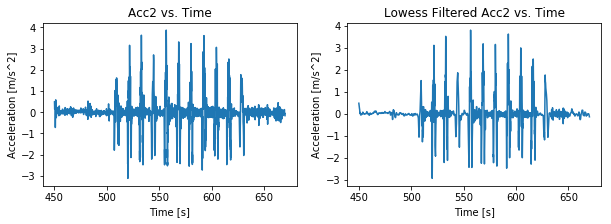

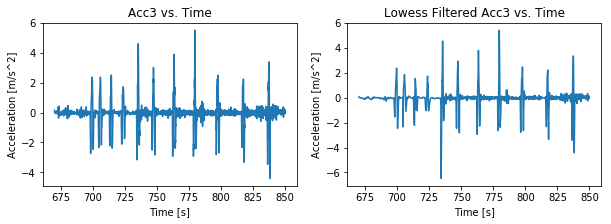

Comments: Here, I'm not sure if the Lowess filtered version of Acc3 is better 
 than the original.


In [98]:
##Now, feed interpolated arrays through a Kalman filter:
##(Actually I'm going to use a LOWESS filter for simplicity)

print("\n")
print("Here, I'm implementing a lowess filter instead of a Kalman \n filter right now because it seems simpler to implement.")
print("\n")

lowess = sm.nonparametric.lowess

#Parameters: takes in (y,x, ...)
filtered1 = lowess(interp_array1, time_array1, frac=0.005, is_sorted=True, return_sorted=False) 
filtered2 = lowess(interp_array2, time_array2, frac=0.002, is_sorted=True, return_sorted=False) 
filtered3 = lowess(interp_array3, time_array3, frac=0.002, is_sorted=True, return_sorted=False) 


##Plotting the filtered results:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

f3 = plt.figure(figsize=(10,3))
ax5 = f3.add_subplot(121)
ax6 = f3.add_subplot(122)


##Subplots for acc1
ax1.plot(time_array1, interp_array1)
ax1.set_title('Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax2.plot(time_array1, filtered1)
ax2.set_title("Lowess Filtered Acc1 vs. Time")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc2
ax3.plot(time_array2, interp_array2)
ax3.set_title('Acc2 vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax4.plot(time_array2, filtered2)
ax4.set_title("Lowess Filtered Acc2 vs. Time")
ax4.set_xlabel("Time [s]")
ax4.set_ylabel('Acceleration [m/s^2]')

##Subplots for acc3
ax5.plot(time_array3, interp_array3)
ax5.set_title('Acc3 vs. Time')
ax5.set_xlabel("Time [s]")
ax5.set_ylabel('Acceleration [m/s^2]')
ax6.plot(time_array3, filtered3)
ax6.set_title("Lowess Filtered Acc3 vs. Time")
ax6.set_xlabel("Time [s]")
ax6.set_ylabel('Acceleration [m/s^2]')

plt.show()

print("Comments: Here, I'm not sure if the Lowess filtered version of Acc3 is better \n than the original.")


## PSD Step 3: FFT of filtered data

Experiment Explanations:
Experiment1: We created 'waves' with amplitude of 1m and period of 6s.
We expect to see a peak at: 1/6s = 0.16 Hz.
Experiment2: We created 'waves' with amplitude 1.5m and period = 4s.
We expect to see a peak at: 1/4s = 0.25 Hz.
Experiment3: We created 'waves' with amplitude of 1m and period of 2s.
We expect to see a peak at: 1/2s = 0.5. Hz.


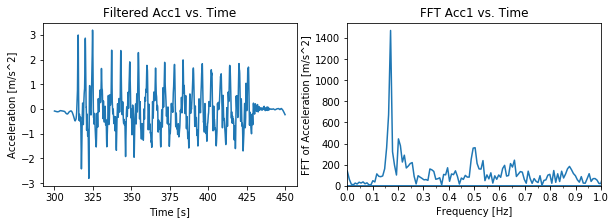

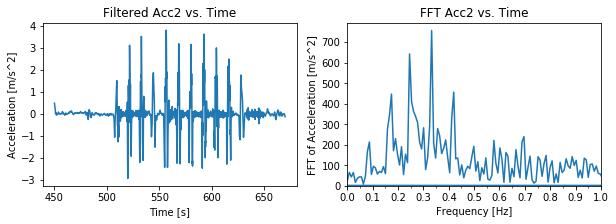

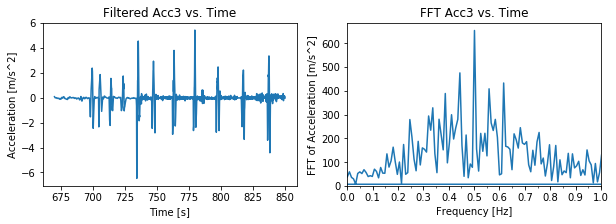

In [122]:
#First, need to fit the data so that the timestamps are *exactly* uniform

#FFT of filtered data
#psd1 = np.fft.fft(filtered1)
#psd2 = np.fft.fft(filtered2)
#psd3 = np.fft.fft(filtered3)

#These are just in case we have diff. rates later
#sampling_rate = 30
#inverse_sampling_rate = 1./sampling_rate
#timestep = inverse_sampling_rate

#For the 30Hz data we will just use timestep = 0.033
timestep = 0.033

fft1 = abs(np.fft.fft(filtered1))
fft2 = abs(np.fft.fft(filtered2))
fft3 = abs(np.fft.fft(filtered3))

n1 = filtered1.size
n2 = filtered2.size
n3 = filtered3.size

fft_freq1 = np.fft.fftfreq(n1, timestep)
fft_freq2 = np.fft.fftfreq(n2, timestep)
fft_freq3 = np.fft.fftfreq(n3, timestep)


##Plotting the psd results:
f1 = plt.figure(figsize=(10,3))
ax1 = f1.add_subplot(121)
ax2 = f1.add_subplot(122)

print("Experiment Explanations:")
print("Experiment1: We created 'waves' with amplitude of 1m and period of 6s.")
print("We expect to see a peak at: 1/6s = 0.16 Hz.")
print("Experiment2: We created 'waves' with amplitude 1.5m and period = 4s.")
print("We expect to see a peak at: 1/4s = 0.25 Hz.")
print("Experiment3: We created 'waves' with amplitude of 1m and period of 2s.")
print("We expect to see a peak at: 1/2s = 0.5. Hz.")



f2 = plt.figure(figsize=(10,3))
ax3 = f2.add_subplot(121)
ax4 = f2.add_subplot(122)

f3 = plt.figure(figsize=(10,3))
ax5 = f3.add_subplot(121)
ax6 = f3.add_subplot(122)


##Subplots for acc1
ax1.plot(time_array1, filtered1)
ax1.set_title('Filtered Acc1 vs. Time')
ax1.set_xlabel("Time [s]")
ax1.set_ylabel('Acceleration [m/s^2]')
ax2.plot(fft_freq1, fft1)
ax2.set_title("FFT Acc1 vs. Time")
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel('FFT of Acceleration [m/s^2]')
ax2.set_xlim(0,1)
ax2.set_ylim(0,)
ax2.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax2.xaxis.set_minor_locator(plt.MultipleLocator(0.05))


##Subplots for acc2
ax3.plot(time_array2, filtered2)
ax3.set_title('Filtered Acc2 vs. Time')
ax3.set_xlabel("Time [s]")
ax3.set_ylabel('Acceleration [m/s^2]')
ax4.plot(fft_freq2, fft2)
ax4.set_title("FFT Acc2 vs. Time")
ax4.set_xlabel("Frequency [Hz]")
ax4.set_ylabel('FFT of Acceleration [m/s^2]')
ax4.set_xlim(0,1)
ax4.set_ylim(0,)
ax4.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax4.xaxis.set_minor_locator(plt.MultipleLocator(0.05))

##Subplots for acc3
ax5.plot(time_array3, filtered3)
ax5.set_title('Filtered Acc3 vs. Time')
ax5.set_xlabel("Time [s]")
ax5.set_ylabel('Acceleration [m/s^2]')
ax6.plot(fft_freq3, fft3)
ax6.set_title("FFT Acc3 vs. Time")
ax6.set_xlabel("Frequency [Hz]")
ax6.set_ylabel('FFT of Acceleration [m/s^2]')
ax6.set_xlim(0,1)
ax6.set_ylim(0,)
ax6.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax6.xaxis.set_minor_locator(plt.MultipleLocator(0.05))

plt.show()



#KaiserBessel window (based on the modified zero-order Bessel function) to reduce
#spectral leakage.

In [ ]:
#Next steps:
#0. 
#1. Take FFT's of surf data
#2. Look for better filtering algorithms